In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

# Data

In [4]:
def GeneratorOfTimeSeries(n = 50, m = 1000):
    X = np.ones([m, n])*np.linspace(start = 0, stop = 10*np.pi, num = n)
    T1 = []
    T2 = []
    for x in X:
        k = np.random.rand(1)
        T1.append(np.sin(k*x) + np.random.randn(n)*0.1)
        T2.append(np.sin(k*x) + np.random.randn(n)*0.1)
        
    T1 = np.asarray(T1)
    T2 = np.asarray(T2)
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1]), np.reshape(T2, [T2.shape[0], T2.shape[1], 1])


In [5]:
X_train, Y_train = GeneratorOfTimeSeries()
X_test, Y_test = GeneratorOfTimeSeries()

# Generator

In [6]:
def batches_generator(batch_size, input, output, shuffle=True, allow_smaller_last_batch=True, device = 'cpu'):
    n_samples = len(input)
    
    list_of_indexes = np.linspace(0, len(input) - 1, len(input), dtype=np.int64)
    list_of_x = []
    list_of_y = []
    
    if shuffle:
        np.random.shuffle(list_of_indexes)
        
    for indx in list_of_indexes:
        list_of_x.append(input[indx])
        list_of_y.append(output[indx])
    
    n_batches = n_samples//batch_size

    if n_samples%batch_size != 0:
        n_batches+=1
        
    for k in range(n_batches):
        this_batch_size = batch_size
        
        if k == n_batches - 1:
            if n_samples%batch_size > 0:
                this_batch_size = n_samples%batch_size
            if allow_smaller_last_batch is False:
                if this_batch_size < batch_size:
                    break

        length_of_sentence_x = 0
        length_of_sentence_y = 0
        for t in range(k*batch_size, k*batch_size + this_batch_size):
            if len(list_of_x[t]) > length_of_sentence_x:
                length_of_sentence_x = len(list_of_x[t])
            if len(list_of_y[t]) > length_of_sentence_y:
                length_of_sentence_y = len(list_of_y[t])
        
        x_arr = np.ones(shape=[this_batch_size, length_of_sentence_x, 1])*0
        y_arr = np.ones(shape=[this_batch_size, length_of_sentence_y, 1])*0
        
        for i in range(this_batch_size):
            for j, (x, y) in enumerate(zip(list_of_x[k*batch_size + i], list_of_y[k*batch_size + i])):
                x_arr[i, j, 0] = x
                y_arr[i, j, 0] = y
                
            
        x_tr = torch.FloatTensor(x_arr)
        y_tr = torch.FloatTensor(y_arr)
        
        x_tr = x_tr.float().to(device)
        y_tr = y_tr.float().to(device)
        yield x_tr, y_tr
    return

# Define LSTM

In [177]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, device = 'cpu'):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        
        self.to(device)

    def forward(self, input):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        
        return data:
        lstm_out has a shape [batch_size, time_len_in, hidden_dim]
        hidden has a shape  [num_layers * num_directions, batch_size, hidden_dim]
        """
        lstm_out, hidden = self.lstm(torch.transpose(input, 0, 1))
        return torch.transpose(lstm_out, 0, 1), hidden
    
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, device = 'cpu'):
        super(Decoder, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.to(device)

    def forward(self, input, hidden = None):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        hidden has a shape [num_layers * num_directions, batch_size, hidden_dim]
        
        return data:
        y_pred has a shape [batch_size, 1, output_dim]
        hidden has a shape  [num_layers * num_directions, batch_size, hidden_dim]
        """
        
        lstm_out, hidden = self.lstm(torch.transpose(input, 0, 1), hidden)
        
        y_pred = torch.transpose(self.linear(lstm_out), 0, 1)
        
        return y_pred, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, num_layers=2, device = 'cpu'):
        super(Attention, self).__init__()
        
        self.hidden_dim = hidden_dim
        
#         self.attn = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.to(device)
    
    def forward(self, h, e):
        """
        input data:
        
        h has a shape [num_directions, batch_size, hidden_dim]
        e has a shape [batch_size, time_len_in,  num_directions * hidden_dim]
        
        return data:
        result has a shape [1, batch_size, hidden_dim]
        """
        alpha = F.softmax((e.unsqueeze(0)*h.unsqueeze(2)).sum(dim = 3), dim = 2)
    
        return (alpha.unsqueeze(3)*e.unsqueeze(0)).sum(dim = 2)
    
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, device = 'cpu'):
        super(seq2seq, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, device)
        
        self.attention = Attention(hidden_dim, num_layers=num_layers)
        
        self.decoder = Decoder(output_dim + hidden_dim, hidden_dim, output_dim, num_layers, device)
    
        self.to(device)
        
    def forward(self, input, max_len = 50):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        max_len is a maximum of generative sentence
        
        return data:
        decoder_out has a shape [batch_size, max_len, output_dim]
    
        """
        decoder_in = torch.zeros(input.shape[0], 1, self.input_dim)
        
        decoder_out = torch.zeros(input.shape[0], max_len, self.output_dim)
        
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        
        for i in range(max_len):
            
            decoder_in = torch.cat((decoder_in, self.attention(encoder_h, encoder_out).view(decoder_in.shape[0], 1, self.hidden_dim)), dim = 2)
            
            decoder_in, (encoder_h, encoder_c) = self.decoder(decoder_in, (encoder_h, encoder_c))            
            decoder_out[:,i,:] = decoder_in[:,0,:]
        
        return decoder_out
    
    def train_on_batch(self, x_batch, y_batch, optimizer, loss_function):
        """
        x_batch has a shape [batch_size, time_len_in, input_dim]
        y_batch has a shape [batch_size, time_len_out, output_dim]
        """
        self.zero_grad()
        output = self.forward(x_batch, max_len = y_batch.shape[1])
    
        loss = loss_function(output, y_batch)
        loss.backward()

        optimizer.step()
        
        return
    
    def pred_loss(self, x_batch, y_batch, loss_function):
        output = self.forward(x_batch, max_len = y_batch.shape[1])
        
        return loss_function(output, y_batch)

In [178]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, device = 'cpu'):
        
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
        self.to(device)


    def forward(self, input):
        lstm_out, self.hidden = self.lstm(torch.transpose(input, 0, 1))
        
        
        y_pred = self.linear(lstm_out)
        return torch.transpose(y_pred, 0, 1)
    
    def train_on_batch(self, x_batch, y_batch, optimizer, loss_function):
        self.zero_grad()
        
        output = self.forward(x_batch)
    
        loss = loss_function(output, y_batch)
        loss.backward()

        optimizer.step()
        
        return


# Train model

In [179]:
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        model.train_on_batch(batch_of_x, batch_of_y, optimizer, loss_function)
    return

In [180]:
def trainer(count_of_epoch, batch_size, 
            X_train, Y_train, X_test, Y_test,
            model, loss_function,
            optimizer, print_results=True, gamma = 0.9, lr = 0.05):
    
    list_of_loss_train = []
    list_of_loss_test = []
    
    X_test_tr = torch.Tensor(X_test)
    X_train_tr = torch.Tensor(X_train)
    
    Y_train_tr = torch.Tensor(Y_train)
    Y_test_tr = torch.Tensor(Y_test)
    for it in tqdm(range(count_of_epoch)):
        optima = optimizer(model.parameters(), lr=lr*(gamma**it))
        batch_generator = batches_generator(
                                            batch_size=batch_size,
                                            input=X_train,
                                            output=Y_train,
                                            shuffle=True,
                                            allow_smaller_last_batch=True
                                        )
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima)
        
        model.eval()
        
        list_of_loss_train.append(model.pred_loss(X_train_tr, Y_train_tr, loss_function).data.numpy())
        list_of_loss_test.append(model.pred_loss(X_test_tr, Y_test_tr, loss_function).data.numpy())
        
    return list_of_loss_train, list_of_loss_test
        

# Define model

In [181]:
# model = LSTM(input_dim = 1, hidden_dim = 10, output_dim = 1, num_layers = 3)

In [182]:
model = seq2seq(input_dim = 1, hidden_dim = 20, output_dim = 1, num_layers = 1)

In [187]:
list_of_train_loss, list_of_test_loss = trainer(count_of_epoch = 100,
                                                batch_size = 64,
                                                X_train = X_train,
                                                Y_train = Y_train,
                                                X_test = X_test,
                                                Y_test = Y_test,
                                                model = model,
                                                loss_function = torch.nn.MSELoss(),
                                                optimizer = torch.optim.Adam,
                                               )

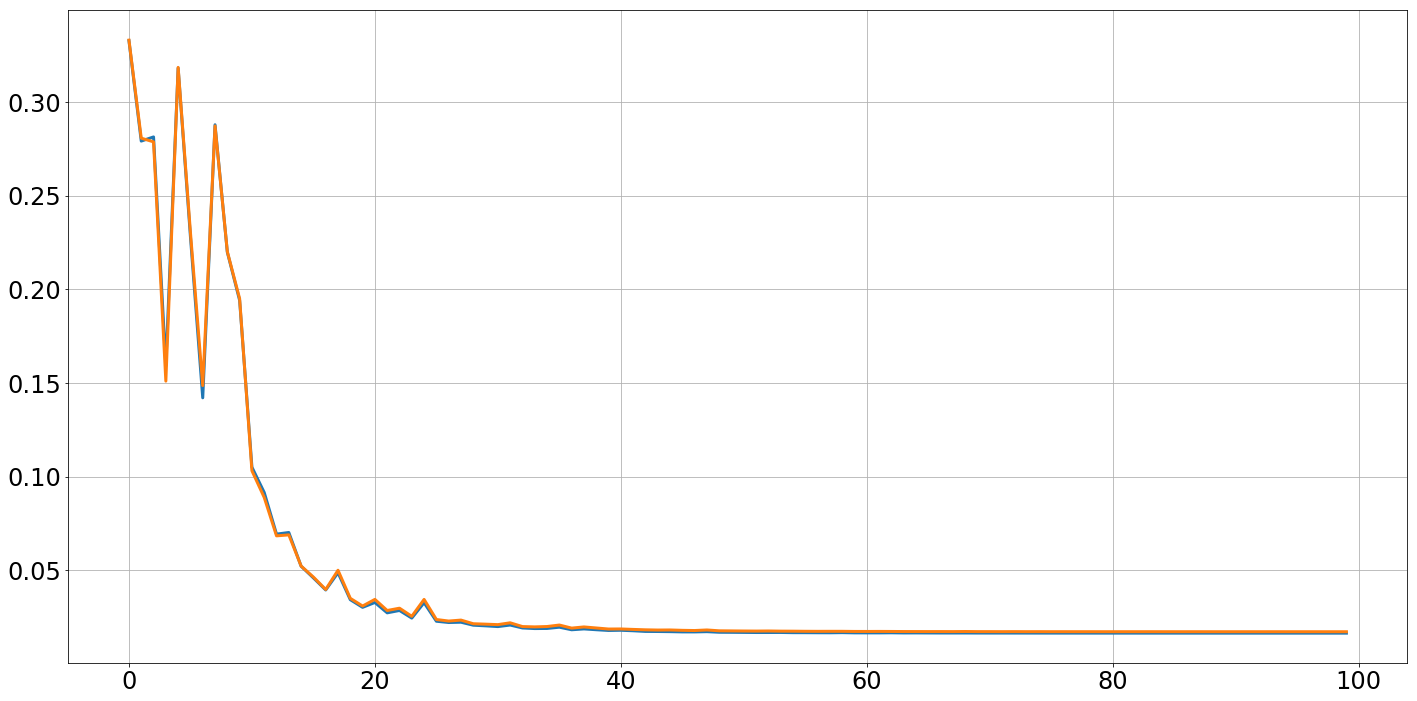

In [188]:
plt.plot(list_of_train_loss)
plt.plot(list_of_test_loss)

plt.grid()

plt.show()

In [189]:
tr_X = torch.Tensor(X_train)
tr_Y = torch.Tensor(Y_train)

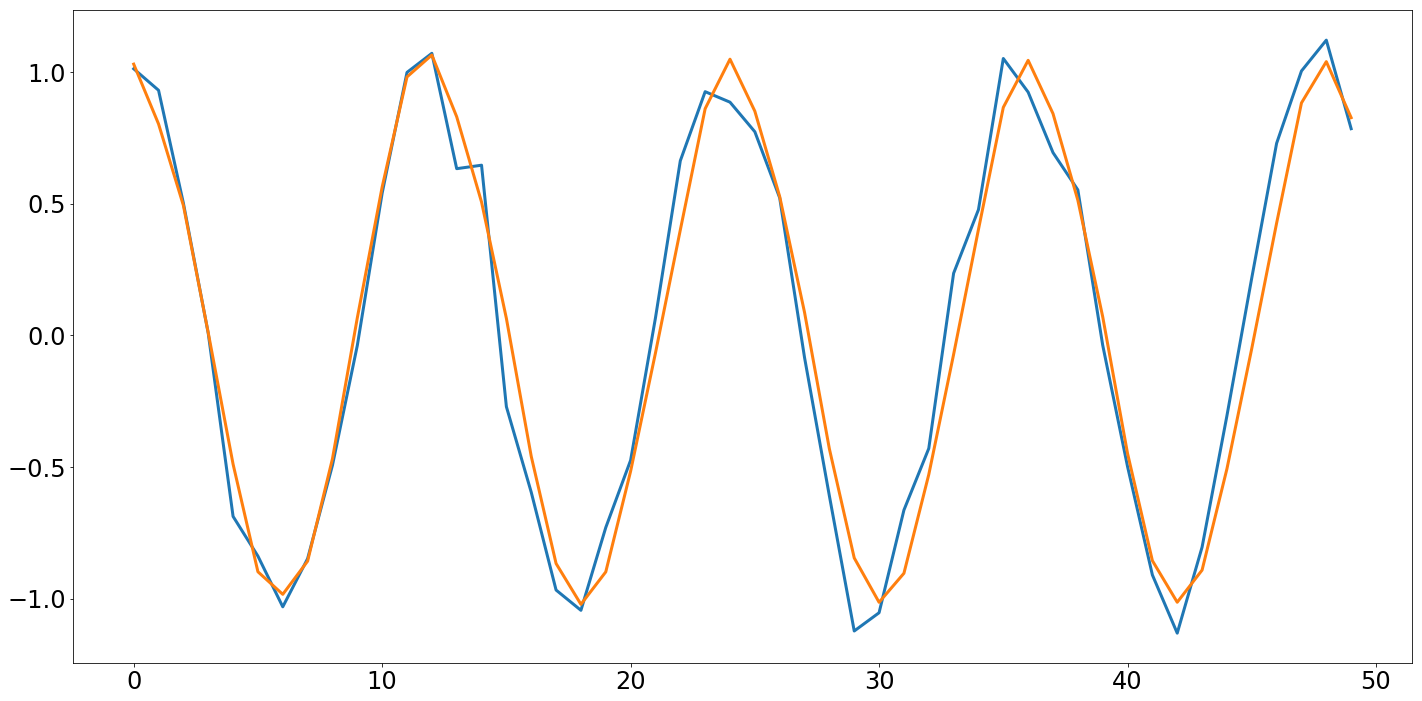

In [190]:
M = 16
plt.plot(np.reshape(np.array(tr_Y[M-1:M]), [-1]))
plt.plot(np.reshape(np.array(model(tr_X[M-1:M]).detach()), [-1]))